Lade NBA-Daten …


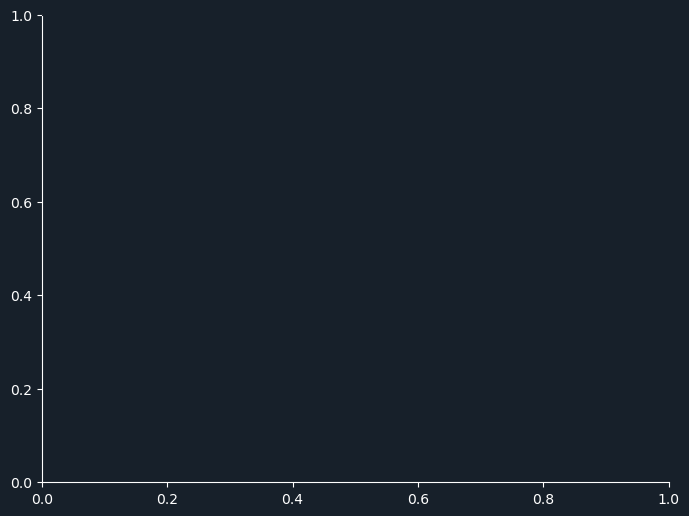

In [2]:
import tkinter as tk
from tkinter import ttk, messagebox, filedialog
from nba_api.stats.endpoints import leaguedashplayerstats
import pandas as pd
import time
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import json
import matplotlib.cm as cm

# --- Daten abrufen ---
print("Lade NBA-Daten …")
stats = leaguedashplayerstats.LeagueDashPlayerStats(season='2023-24').get_data_frames()[0]
time.sleep(1)
stats = stats[['PLAYER_NAME', 'TEAM_ABBREVIATION', 'GP', 'PTS', 'REB', 'AST', 'STL', 'BLK', 'FG3M']]
stats[['PTS', 'REB', 'AST', 'STL', 'BLK', 'FG3M']] = stats[['PTS', 'REB', 'AST', 'STL', 'BLK', 'FG3M']].div(stats['GP'], axis=0)
stats_df = stats.set_index('PLAYER_NAME').sort_index()

# --- GUI Setup ---
root = tk.Tk()
root.title("NBA Spieler Vergleicher mit Auswahl der Statistik")
root.geometry("1150x700")
root.configure(bg="#17202A")

style = ttk.Style(root)
style.theme_use("clam")
style.configure("TButton", font=('Segoe UI', 10, 'bold'), background="#1D428A", foreground="white")
style.map("TButton", background=[('active', '#A10E1E')], foreground=[('active', 'white')])

# --- Layout Frames ---
left_frame = tk.Frame(root, bg="#17202A")
left_frame.pack(side="left", fill="y", padx=20, pady=20)

right_frame = tk.Frame(root, bg="#17202A")
right_frame.pack(side="right", fill="both", expand=True, padx=20, pady=20)

# --- Dropdown für Statistik-Auswahl ---
stat_options = ['PTS', 'REB', 'AST', 'STL', 'BLK', 'FG3M']
selected_stat = tk.StringVar(value=stat_options[0])

tk.Label(left_frame, text="Statistik auswählen:", fg="white", bg="#17202A", font=('Segoe UI', 12)).pack(anchor="w", pady=(0,5))
stat_dropdown = ttk.Combobox(left_frame, values=stat_options, textvariable=selected_stat, state="readonly", font=('Segoe UI', 11), width=10)
stat_dropdown.pack(anchor="w", pady=(0,15))

# --- Diagrammtyp Dropdown ---
chart_types = ['Balken', 'Linie']
selected_chart_type = tk.StringVar(value=chart_types[0])
tk.Label(left_frame, text="Diagrammtyp:", fg="white", bg="#17202A", font=('Segoe UI', 12)).pack(anchor="w")
chart_type_dropdown = ttk.Combobox(left_frame, values=chart_types, textvariable=selected_chart_type, state="readonly", font=('Segoe UI', 11), width=10)
chart_type_dropdown.pack(anchor="w", pady=(0,15))

# --- Suchfeld & Spieler-Liste ---
tk.Label(left_frame, text="Spieler suchen:", fg="white", bg="#17202A", font=('Segoe UI', 12)).pack(anchor="w")
search_var = tk.StringVar()
search_entry = tk.Entry(left_frame, textvariable=search_var, font=('Segoe UI', 11), width=25)
search_entry.pack(anchor="w", pady=(0, 10))

listbox_frame = tk.Frame(left_frame)
listbox_frame.pack()

scrollbar_y = tk.Scrollbar(listbox_frame, orient="vertical")
scrollbar_y.pack(side="right", fill="y")

player_listbox = tk.Listbox(listbox_frame, selectmode="multiple", height=25, width=30,
                            yscrollcommand=scrollbar_y.set, font=('Segoe UI', 11))
player_listbox.pack(side="left", fill="y")
scrollbar_y.config(command=player_listbox.yview)

all_player_names = list(stats_df.index)
for name in all_player_names:
    player_listbox.insert("end", name)

# --- Spieler-Daten-Label ---
player_data_label = tk.Label(left_frame, text="", fg="white", bg="#17202A", font=('Segoe UI', 11), justify="left")
player_data_label.pack(pady=20, anchor="w")

# --- Matplotlib Diagramm vorbereiten ---
fig, ax = plt.subplots(figsize=(7,5), dpi=100)
fig.patch.set_facecolor('#17202A')
ax.set_facecolor('#17202A')
ax.tick_params(colors='white')
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_color('white')
ax.spines['top'].set_color('#17202A')
ax.spines['right'].set_color('#17202A')

canvas = FigureCanvasTkAgg(fig, master=right_frame)
canvas.get_tk_widget().pack(fill="both", expand=True)

# --- Buttons unter Diagramm ---
button_frame = tk.Frame(right_frame, bg="#17202A")
button_frame.pack(pady=10)

ttk.Button(button_frame, text="Diagramm speichern", command=lambda: save_diagram()).grid(row=0, column=0, padx=10)
ttk.Button(button_frame, text="Spieler entfernen", command=lambda: remove_selected_player()).grid(row=0, column=1, padx=10)
ttk.Button(button_frame, text="Auswahl speichern", command=lambda: save_selection()).grid(row=0, column=2, padx=10)
ttk.Button(button_frame, text="Auswahl laden", command=lambda: load_selection()).grid(row=0, column=3, padx=10)

# --- Status ---
selected_players = []

# --- Diagramm zeichnen ---
def draw_plot():
    stat = selected_stat.get()
    chart_type = selected_chart_type.get()
    texts = []
    values = []
    labels = []
    
    for name in selected_players:
        if name in stats_df.index:
            row = stats_df.loc[name]
            texts.append(f"{name} ({row['TEAM_ABBREVIATION']}): {row[stat]:.1f} {stat}")
            values.append(row[stat])
            labels.append(name)

    player_data_label.config(text="\n".join(texts))

    ax.clear()
    ax.set_facecolor('#17202A')
    ax.tick_params(colors='white', labelsize=10)
    ax.spines['bottom'].set_color('white')
    ax.spines['left'].set_color('white')
    ax.spines['top'].set_color('#17202A')
    ax.spines['right'].set_color('#17202A')

    colors = cm.tab10.colors

    if chart_type == "Balken":
        bars = ax.bar(labels, values, color=colors[:len(values)])
        for bar, val in zip(bars, values):
            ax.text(bar.get_x() + bar.get_width()/2, val + 0.05, f'{val:.1f}', ha='center', color='white', fontsize=10)
    elif chart_type == "Linie":
        ax.plot(labels, values, marker='o', color=colors[0])
        for i, val in enumerate(values):
            ax.text(i, val + 0.05, f'{val:.1f}', ha='center', color='white', fontsize=10)

    ax.set_title(f'{stat} pro Spiel der ausgewählten Spieler', color='white', fontsize=14)
    ax.set_ylim(0, max(values) * 1.2 if values else 1)
    
    if values:
        avg_val = sum(values) / len(values)
        ax.axhline(avg_val, color='red', linestyle='--', linewidth=2, label=f'Durchschnitt: {avg_val:.2f} {stat}')
        ax.legend(facecolor='#17202A', labelcolor='white')

    canvas.draw()

# --- Auswahl aktualisieren ---
def update_player_info(event=None):
    global selected_players
    new_selections = [player_listbox.get(i) for i in player_listbox.curselection()]
    for name in new_selections:
        if name not in selected_players:
            selected_players.append(name)
    if len(selected_players) > 5:
        messagebox.showwarning("Auswahl zu groß", "Bitte maximal 5 Spieler auswählen.")
        selected_players = selected_players[:5]
    draw_plot()

# --- Spieler entfernen ---
def remove_selected_player():
    global selected_players
    if not selected_players:
        messagebox.showinfo("Keine Spieler", "Es sind keine Spieler ausgewählt.")
        return

    remove_window = tk.Toplevel(root)
    remove_window.title("Spieler entfernen")
    remove_window.configure(bg="#17202A")

    tk.Label(remove_window, text="Wähle einen Spieler zum Entfernen:", bg="#17202A", fg="white", font=('Segoe UI', 11)).pack(padx=10, pady=10)

    var = tk.StringVar(value=selected_players[0])
    for name in selected_players:
        tk.Radiobutton(remove_window, text=name, variable=var, value=name, bg="#17202A", fg="white", selectcolor="#1D428A", font=('Segoe UI', 10)).pack(anchor="w", padx=20)

    def confirm_remove():
        selected_name = var.get()
        if selected_name in selected_players:
            selected_players.remove(selected_name)
            draw_plot()
            remove_window.destroy()

    ttk.Button(remove_window, text="Entfernen", command=confirm_remove).pack(pady=10)

# --- Diagramm speichern ---
def save_diagram():
    file_path = filedialog.asksaveasfilename(defaultextension=".png", filetypes=[("PNG Dateien", "*.png")], title="Diagramm speichern unter...")
    if file_path:
        fig.savefig(file_path)
        messagebox.showinfo("Erfolg", f"Diagramm wurde gespeichert unter:\n{file_path}")

# --- Auswahl speichern ---
def save_selection():
    file_path = filedialog.asksaveasfilename(defaultextension=".json", filetypes=[("JSON Dateien", "*.json")], title="Auswahl speichern als...")
    if file_path:
        with open(file_path, 'w') as f:
            json.dump(selected_players, f)
        messagebox.showinfo("Gespeichert", "Auswahl erfolgreich gespeichert.")

# --- Auswahl laden ---
def load_selection():
    global selected_players
    file_path = filedialog.askopenfilename(filetypes=[("JSON Dateien", "*.json")], title="Auswahl laden...")
    if file_path:
        with open(file_path, 'r') as f:
            selected_players = json.load(f)
        draw_plot()
        messagebox.showinfo("Geladen", "Spielerauswahl erfolgreich geladen.")

# --- Spieler filtern ---
def filter_players(*args):
    search = search_var.get().lower()
    player_listbox.delete(0, 'end')
    for name in all_player_names:
        if search in name.lower():
            player_listbox.insert('end', name)

# --- Events ---
search_var.trace_add('write', filter_players)
player_listbox.bind('<<ListboxSelect>>', update_player_info)
stat_dropdown.bind('<<ComboboxSelected>>', lambda e: draw_plot())
chart_type_dropdown.bind('<<ComboboxSelected>>', lambda e: draw_plot())

root.mainloop()
